# Image Segmentation with GraB Algorithm

Image segmentation is an important machine intelligence task which has found use in blah blah blah

In this project, we will implement the GraB Algorithm as found in this paper:- "GraB: Visual Saliency via Novel Graph Model and Background Priors".

To start out with we explore some images from the THUS10K database which we downloaded from link https://mmcheng.net/msra10k.

Then we also download all the libraries that we will need.


In [11]:
#Run following cell once only then comment out

#!unzip MSRA10K_Imgs_GT.zip

In [38]:
data_dir = 'MSRA10K_Imgs_GT/Imgs/'

import lm

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import math
import time

from IPython.display import Image, display
from glob import glob
   
from skimage import  color
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float, dtype_limits
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import scipy
from scipy.sparse.csgraph import dijkstra as dkstra

#from fast_histogram import histogram1d

%matplotlib inline

When we plot out the individual images from the data directory we unzipped above, it is pretty clear that the data is divided between jpg and png file formats where the jpg is the original image and the png file format is the modified image with the saliency map.

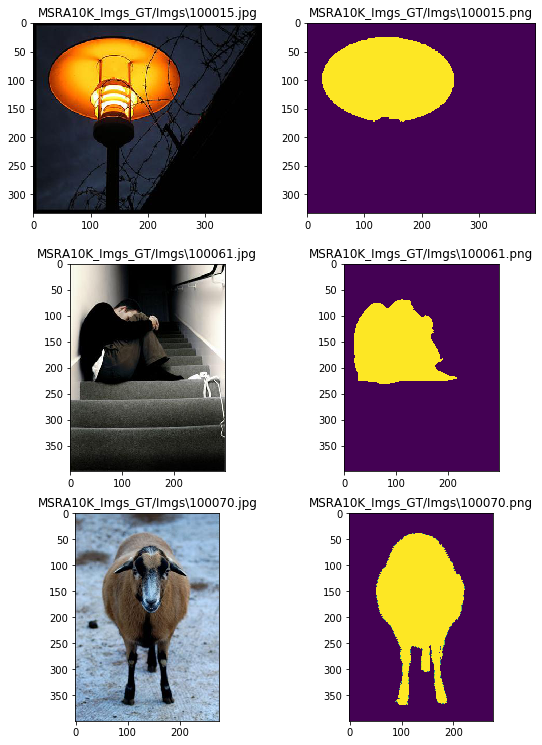

In [39]:


listofImageNames = glob('MSRA10K_Imgs_GT/Imgs/*', recursive=True)
# use a created array to output multiple images.
    
fig=plt.figure(figsize=(9, 13))
columns = 2
rows = 3

ax = []

for i in range(0, columns*rows):
    img = plt.imread(listofImageNames[i])
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(listofImageNames[i])
    plt.imshow(img)

plt.show()

Okay so this is interesting. The original files are colored while the saliency maps are essentially black and white maps. Also the database does not have all images of the same size. We notice that the file names are the same except for the extension denoting the file format. In this case, we can read in all the .jpg file formats and modify to obtain the target file names by replacing .jpg with .png. Then we can reference individual image pairs with their index.

In [40]:
listOfImgName_X = glob('MSRA10K_Imgs_GT/Imgs/*.jpg', recursive=True)

listOfImgName_Y = listOfImgName_X.copy()

for i in range(len(listOfImgName_Y)) :
    name = listOfImgName_Y[i]
    name = name[0:-3]+'png'
    listOfImgName_Y[i] = name

print(listOfImgName_X[0])
print(listOfImgName_Y[0])

MSRA10K_Imgs_GT/Imgs\100015.jpg
MSRA10K_Imgs_GT/Imgs\100015.png


Okay let's do the first task of the Algorithm now and build the superpixels using the Simple Linear Iterative Clustering Algorithm. First, let's select a random image sample to play with.

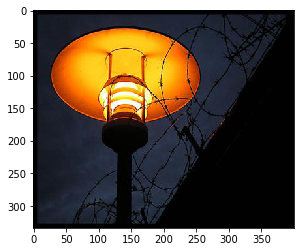

In [41]:
image = listOfImgName_X[0]
plt.figure()
img_sample = plt.imread(image)
plt.imshow(img_sample)
plt.show()

Then we can process the image above with a ready made implementation of the Simple Linear Iterative Clustering Algorithm from skimage.segmentation. The paper is unclear about how many segments to divide the image into so lets take a look and see how different number of segments look.

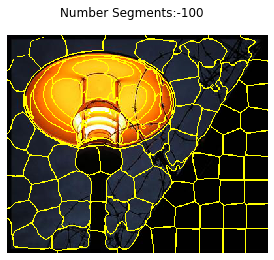

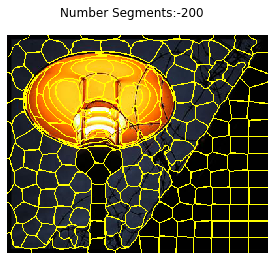

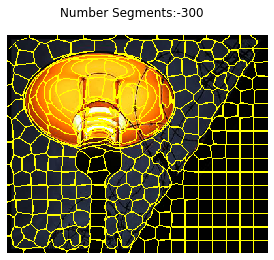

In [47]:

image = img_as_float(img_sample)

for num in (100, 200, 300):
    segments = slic(image, n_segments = num, sigma = 3, convert2lab=True)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle("Number Segments:-" + str(num))
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")

To be honest, all segments look roughly the same as far as distringuishing between boundaries. To optimize on time, we will use N=300 segments for this implementation.

In [6]:
numSegments = 300

def SuperPixels (image, n_segments) :
    super_pix = slic(image, n_segments = n_segments, sigma = 3, convert2lab=True)
    return super_pix

super_pixels = SuperPixels (image, numSegments)

The next thing we need to do is create an adjacency matrix $A_{ij}$ where each pair of superpixels (i,j) with a border have a weight of $A_{ij}$ = $A_{ji}$ = 1. To do this, we need to iterate over the segments array where segments[n,m] correspond to the segment that pixel in image[n,m] is partitioned into. In addition, we can also take this time to create subset of superpixels that correspond to each border, i.e. $B_{Left}$ and $B_{Top}$ would correspond to the left and top border respectively.

In [7]:
def makeAdjMatrix (super_pixels) :
    
    (height,width) = (super_pixels.shape)
    numInd = np.max(super_pixels) + 1 - np.min(super_pixels)
    
    Adjacency_ij = np.zeros((numInd,numInd))
    
    sm_0_1 = super_pixels[:,0:width-1]
    sm_1_w = super_pixels[:,1:width]
    c1 = (sm_0_1 != sm_1_w)
    
    for x, y in zip(sm_0_1[c1], sm_1_w[c1]) :
        Adjacency_ij[int(x),int(y)] =1
        Adjacency_ij[int(y),int(x)] =1
    
    sm_1_0 = super_pixels[0:height-1,:]
    sm_1_h = super_pixels[1:height,:]
    c2 = (sm_1_0 != sm_1_h)
    
    for x, y in zip(sm_1_0[c2], sm_1_h[c2]) :
        Adjacency_ij[int(x),int(y)] =1
        Adjacency_ij[int(y),int(x)] =1
        
    return Adjacency_ij, numInd

Adjacency_ij, numInd = makeAdjMatrix(super_pixels)

def makeBorderset(super_pixels) :      

    (height,width) = (super_pixels.shape)
    
    B_Top = list(set(super_pixels[0,0:width-1]))
    B_Bot = list(set(super_pixels[height-1,0:width-1]))
    B_Left = list(set(super_pixels[0:height-1,0]))
    B_Right = list(set(super_pixels[0:height-1,width-1]))
    
    BorderSet = {0 : B_Top , 1 : B_Bot, 2 :B_Left, 3 :B_Right}
    
    return BorderSet

BorderSet = makeBorderset(super_pixels)

print(Adjacency_ij[0:10,0:10])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


As we can see, the adjacency matrix is symmetric. This is what we wanted as we expect the Adjacency matrix to be unidirectional.

Now let's start to create a regional feature descriptor r that encapsulates color and texture cues for each superpixel. First, for color features, we calculate the CIELAB color space for each superpixel. We will eventually need to take a look at the mean L * a * b and histogram values of L * a * b values. We can see that the L * a * b image is actually pretty good at picking out the color delta from the lamp.

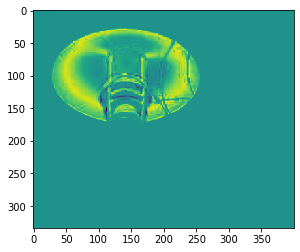

In [8]:
def makeLabImage(image) :
    lab = color.rgb2lab(image)

    lab_Image = lab[:,:,0]*lab[:,:,1]*lab[:,:,2]

    minIm = np.min(lab_Image)
    maxIm = np.max(lab_Image)

    lab_Image = 1.0*(lab_Image - minIm)/(maxIm-minIm+0.000001)
    
    return lab_Image

lab_Image = makeLabImage(image)

plt.figure()
plt.imshow(lab_Image)
plt.show()


Next for texture features, we import the Leung-Malik (LM) ﬁlter bank and calculate the max LM response for each pixel. We will eventually also have to create histograms of this for each superpixel. We download the LM filter bank from open source github project from following path and download it to our directory:- https://github.com/CVDLBOT/LM_filter_bank_python_code.git . The code was modified only a little bit to fix the scale parameters and also to update it to work on python3.

In [9]:

F = lm.makeLMfilters()
print (F.shape)
# This runs the python file and creates the filters stored in variable F and prints F.shape

(49, 49, 48)


Now we can print out the filter bank and see what each filter looks like

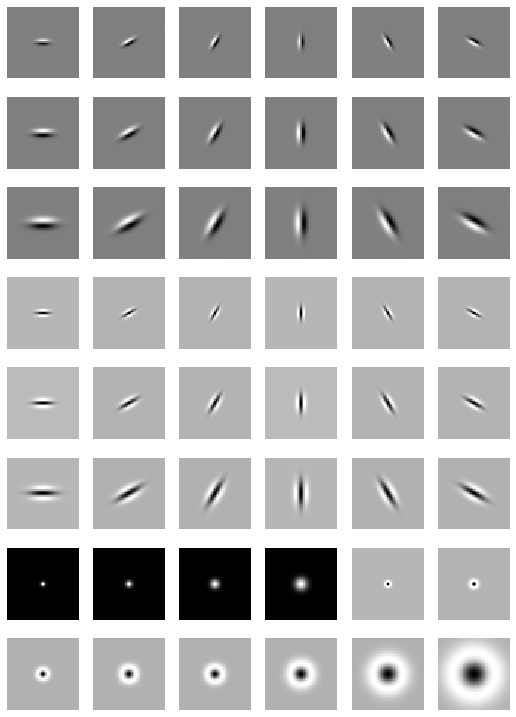

In [10]:
plt.figure(figsize=(9, 13))
    
for i in range(0,48): 
    plt.subplot(8,6,i+1) 
    plt.axis('off') 
    plt.imshow(F[:,:,i], cmap = 'gray')


Basically, the filters correspond to different types of shapes and edges we may expect to see. We can now convolve these filters with our image to create a filter response stack of 48 images. Then according to the paper, we are only interested in the max response of the filter for each pixel.

In [11]:
def make_LM_Filter(image, F) :
    
    image_grey = color.rgb2gray(image)
    
    (height,width) = (image_grey.shape)

    filter_response = np.zeros((height,width,48))

    for i in range(48) :
        filter_response[:,:,i] = scipy.signal.fftconvolve(image_grey, F[:,:,i], mode='same')
        
    max_LM_filter = np.amax(filter_response,axis=2)

    minIm = np.min(max_LM_filter)
    maxIm = np.max(max_LM_filter)

    max_LM_filter = 1.0*(max_LM_filter - minIm)/(maxIm-minIm+0.000001)
    
    return max_LM_filter

max_LM_filter = make_LM_Filter(image, F)


(334, 400)


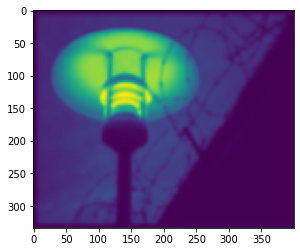

0.0 0.9999998526997951


In [12]:
print(max_LM_filter.shape)

plt.figure()
plt.imshow(max_LM_filter)
plt.show()

print(np.min(max_LM_filter), np.max(max_LM_filter))

As suspected, the max LM response filter highlights texture cues much better in the image. One can even see the small fence wires.

Now that we have our two images, it is time to aggregate them into the regional feature descriptors. Essentially, we need to store the distribution of pixels in each superpixel for both the feature and color image, corresponding to the max_LM_filter and lab_Image variable, and get the average of the color image for each super pixel.

In [13]:
def makeRegionalDescriptors(super_pixels, lab_Image, max_LM_filter, numInd) : 
    
    reg_desc_col = {i:lab_Image[(super_pixels == i)] for i in range(numInd)}
    reg_desc_tex = {i:max_LM_filter[(super_pixels == i)] for i in range(numInd)}
    reg_desc_col_ave = {i:sum(reg_desc_col [i])/len(reg_desc_col [i]) for i in range(numInd)}
        
    return reg_desc_col, reg_desc_tex, reg_desc_col_ave

reg_desc_col, reg_desc_tex, reg_desc_col_ave = makeRegionalDescriptors(super_pixels, lab_Image, max_LM_filter, numInd)

print(reg_desc_col_ave[0])

0.5121739333874492


The three variables defined in the cell above compromise our regional feature descriptor. Now that we have these values, we can define the distance between each superpixel. To do this, we first, need to define the Chi-squared distance between histograms.

In [14]:
def ChiSquaredDistance(array1, array2, K = 16) :
    #minA = min(min(array1),min(array2))
    #maxA = max(max(array1),max(array2))
    
    #print(minA, maxA, 1.0*(maxA-minA)/K)
    #if minA == maxA :
    #    return 0
    
    #interval = np.arange(start = 0, stop = 1, step = 1.0/K)
    
    hist1 = np.histogram(array1, bins=K, range=(0, 1))
    hist2 = np.histogram(array2, bins=K, range=(0, 1))
    
    hist1d = hist1[0] / len(array1)
    hist2d = hist2[0] / len(array2)
    
    den = hist1d + hist2d + 0.00001
    num = ((hist1d-hist2d)**2)
    sumi = 2*num/den
    
    #sumi = list(filter(lambda x: math.isnan(x) == False, sumi))
    
    return np.sum(sumi)


Next we calculate the Geodesic distance between pixels that are adjacent to one another. We set the distance on those pixels not bordering one another to an arbitrary large number for now.

In [15]:
def GeodDist(desc_Col, desc_Tex, Ave_Col, Adjacency_ij, lamda1 = 0.25, lamda2 = 0.45, lamda3 =0.3, K = 16) :
    
    numInd = len(Ave_Col)
    
    distance = np.zeros((numInd,numInd))
    
    x = np.ones((numInd,numInd))
    
    y = np.ones((numInd,numInd))

    x = np.cumsum(x,axis=1) - 1

    y = np.cumsum(y,axis=0) - 1

    for i, j in zip(x[Adjacency_ij==1], y[Adjacency_ij==1]) :
        i = int(i)
        j = int(j)
        distance[i,j] = lamda1 *np.abs(Ave_Col[i] - Ave_Col[j])
        distance[i,j] += lamda2 *ChiSquaredDistance(desc_Col[i], desc_Col[j], K=K)
        distance[i,j] += lamda3 *ChiSquaredDistance(desc_Tex[i], desc_Tex[j], K=K)
    
    distance[Adjacency_ij==0] = 999999     
    
    distance[np.eye(numInd)==1] = 0
    
    return distance

In [16]:

GeoDist = GeodDist(reg_desc_col, reg_desc_tex, reg_desc_col_ave, Adjacency_ij)

print(GeoDist[0:7,0:7])

[[0.00000000e+00 6.11164396e-02 9.99999000e+05 9.99999000e+05
  9.99999000e+05 9.99999000e+05 9.99999000e+05]
 [6.11164396e-02 0.00000000e+00 5.64221911e-03 9.99999000e+05
  9.99999000e+05 9.99999000e+05 9.99999000e+05]
 [9.99999000e+05 5.64221911e-03 0.00000000e+00 4.24648342e-02
  9.99999000e+05 9.99999000e+05 9.99999000e+05]
 [9.99999000e+05 9.99999000e+05 4.24648342e-02 0.00000000e+00
  5.67631436e-01 9.99999000e+05 9.99999000e+05]
 [9.99999000e+05 9.99999000e+05 9.99999000e+05 5.67631436e-01
  0.00000000e+00 5.62516453e-01 9.99999000e+05]
 [9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
  5.62516453e-01 0.00000000e+00 4.42881237e-04]
 [9.99999000e+05 9.99999000e+05 9.99999000e+05 9.99999000e+05
  9.99999000e+05 4.42881237e-04 0.00000000e+00]]


Next we calculate the minimum distance between each pair of superpixels using Djikstra's algorithm. The code for this part of the routine is available in a scipy library.

In [17]:
GeoDist = dkstra(GeoDist)

print(GeoDist[0:7,0:7])

[[0.00000000e+00 6.11164396e-02 6.67586587e-02 1.09223493e-01
  6.76854929e-01 1.23937138e+00 1.23981426e+00]
 [6.11164396e-02 0.00000000e+00 5.64221911e-03 4.81070533e-02
  6.15738489e-01 1.17825494e+00 1.17869782e+00]
 [6.67586587e-02 5.64221911e-03 0.00000000e+00 4.24648342e-02
  6.10096270e-01 1.17261272e+00 1.17305560e+00]
 [1.09223493e-01 4.81070533e-02 4.24648342e-02 0.00000000e+00
  5.67631436e-01 1.13014789e+00 1.13059077e+00]
 [6.76854929e-01 6.15738489e-01 6.10096270e-01 5.67631436e-01
  0.00000000e+00 5.62516453e-01 5.62959335e-01]
 [1.23937138e+00 1.17825494e+00 1.17261272e+00 1.13014789e+00
  5.62516453e-01 0.00000000e+00 4.42881237e-04]
 [1.23981426e+00 1.17869782e+00 1.17305560e+00 1.13059077e+00
  5.62959335e-01 4.42881237e-04 0.00000000e+00]]


Now that we have our regional field descriptors, it is time to create a matrix to define those vertices connected two hops away; one that connects all pixels out of the border region with all pixels inside the Border; and one matrix to designate all boundary pixels connected to each other.

In [18]:
def makeEdgeGroups(Adjacency_ij, BorderSet, numInd) :

    Edge_Group_2 = np.zeros((numInd,numInd))
    Edge_Group_3 = np.zeros((numInd,numInd))
    
    a = []
    for i in BorderSet :
        a += BorderSet[i]

    B_All = list(set(a))
    
    TwoHops = np.matmul(Adjacency_ij,Adjacency_ij)
    
    TwoHops = (TwoHops>0)*1.0 - Adjacency_ij - np.eye(numInd)
    
    TwoHops = 1.0*(TwoHops==1)

    iB = [i for i in range(numInd) if i not in B_All]
    
    
    Edge_Group_2[iB,:] = 1
    Edge_Group_2[:,B_All] += 1
    
    Edge_Group_2 = (Edge_Group_2==2)*1.0
    
    Edge_Group_2 = Edge_Group_2 + Edge_Group_2.T
    
    Edge_Group_2 = Edge_Group_2 - Adjacency_ij - TwoHops
    
    Edge_Group_2 = 1.0*(Edge_Group_2==1)
        
    Edge_Group_3[B_All,:] =1
    Edge_Group_3[:,B_All] +=1
    
    Edge_Group_3 = (Edge_Group_3==2)*1.0
    
    Edge_Group_3 = Edge_Group_3 - Adjacency_ij - TwoHops - np.eye(numInd)
    
    Edge_Group_3 = 1.0*(Edge_Group_3==1)
                    
    return TwoHops, Edge_Group_2, Edge_Group_3, B_All


TwoHops, Edge_Group_2, Edge_Group_3, B_All = makeEdgeGroups(Adjacency_ij, BorderSet, numInd)

In [19]:
print(TwoHops[0:10,0:10]) 
print(Adjacency_ij[0:10,0:10])
print(Edge_Group_2[0:10,0:10])
print(Edge_Group_3[0:10,0:10])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0.

Now that we have a mask for all our edge conditions, we can create the weight_matrix and mask it with the edges as needed.

In [20]:
def makeWeightMatrix(numInd,Adjacency_ij,TwoHops,Edge_Group_2,Edge_Group_3,GeoDist,B_All, sigma2 = -0.1) :

    weight_matrix = np.zeros((numInd,numInd))

    mask_Edges = TwoHops + Adjacency_ij + 1.0*Edge_Group_2/len(B_All) + Edge_Group_3 #+ np.eye(numInd)

    weight_matrix = np.exp(GeoDist / sigma2) * mask_Edges
    
    return weight_matrix

weight_matrix = makeWeightMatrix(numInd,Adjacency_ij,TwoHops,Edge_Group_2,Edge_Group_3,GeoDist,B_All)

#print(mask_Edges[11:20,21:28])
print(weight_matrix[1:8,1:8])

[[0.00000000e+00 9.45140022e-01 6.18121318e-01 2.11778427e-03
  7.63666608e-06 7.60291951e-06 7.07613632e-06]
 [9.45140022e-01 0.00000000e+00 6.53999729e-01 2.24070955e-03
  8.07993092e-06 8.04422554e-06 7.48686560e-06]
 [6.18121318e-01 6.53999729e-01 0.00000000e+00 3.42616280e-03
  1.23546395e-05 1.23000442e-05 1.14478115e-05]
 [2.11778427e-03 2.24070955e-03 3.42616280e-03 0.00000000e+00
  3.60596978e-03 3.59003493e-03 3.34129232e-03]
 [7.63666608e-06 8.07993092e-06 1.23546395e-05 3.60596978e-03
  0.00000000e+00 9.95580980e-01 9.26600200e-01]
 [7.60291951e-06 8.04422554e-06 1.23000442e-05 3.59003493e-03
  9.95580980e-01 0.00000000e+00 9.30713039e-01]
 [7.07613632e-06 7.48686560e-06 1.14478115e-05 3.34129232e-03
  9.26600200e-01 9.30713039e-01 0.00000000e+00]]


One of the features of this algorithm is that it assumed the three border prior. Namely that in all images at least, three of the borders are going to associated with the background with only one border possibly associated with the foreground or object of interest. As a result, part of the algorithm calls for measuring the distance between the agglomerated pixels on each border and dropping the border that looks the most different from the others (i.e. which has the greatest distance from the others).

In [21]:

def chooseBorderExclude(BorderSet, reg_desc_col, reg_desc_tex) :
    
    reg_desc_col_Bound = { 0 : [ ], 1 : [ ], 2 : [ ], 3 : [ ]}
    reg_col_Ave_Bound = { 0 : 0, 1 : 0, 2 : 0, 3 : 0}
    reg_desc_tex_Bound = { 0 : [ ], 1 : [ ], 2 : [ ], 3 : [ ]}

    for i in BorderSet:
        for k in BorderSet[i] :
            a = reg_desc_col_Bound[i]
            a += list(reg_desc_col[k])
            reg_desc_col_Bound[i] = a
            a = reg_desc_tex_Bound[i]
            a += list(reg_desc_tex[k])
            reg_desc_col_Bound[i] = a
        a = reg_desc_col_Bound[i]
        reg_col_Ave_Bound[i] = sum(a)/len(a)
        
    adj = np.ones((4,4)) - np.identity(4)
    
    BoundDist = GeodDist(reg_desc_col_Bound, reg_desc_tex_Bound, reg_col_Ave_Bound, adj)
    
    return(np.argmax(np.sum(BoundDist, axis=0)))

BoundRemove = chooseBorderExclude(BorderSet, reg_desc_col, reg_desc_tex)

BorderSet.pop(BoundRemove)

print(BorderSet)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 1: [259, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277], 2: [0, 259, 165, 103, 72, 135, 44, 237, 210, 85, 24, 184]}


Okay it seems like it has gotten rid of the border on the right. This makes sense as this is the most different border from the rest having that big wall. Next we get our first estimate of our foreground probability by the following equation:-

In [22]:
def createDiagonal(weight_matrix) :
    a = np.sum(weight_matrix, axis=0)
    D = np.identity(len(a))*a
    
    return D

Diag = createDiagonal(weight_matrix)

print(Diag[1:10,1:10])

[[2.16485826 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         2.15656972 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.63548467 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.19956046 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         2.91914578 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.92813104
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  2.933181   0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         3.00096307 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         3.18790753]]


0.999999942619458 0.0


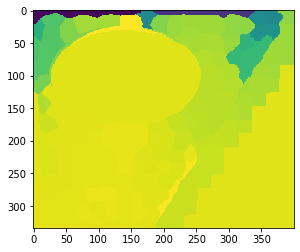

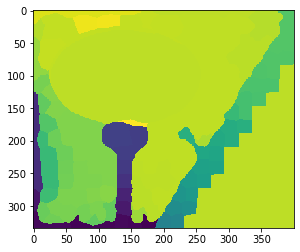

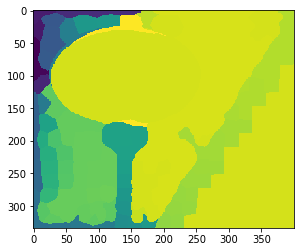

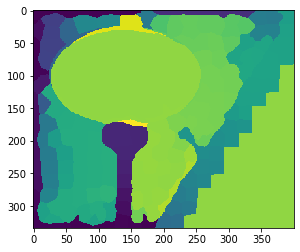

In [23]:
def calculateSaliencyprob(Diag,weight_matrix, BorderSet, numInd, mew = 0.99, damp = 0.001) :
    #inverseMat = scipy.linalg.pinv(Diag - mew*weight_matrix)
    A = Diag - mew*weight_matrix
    F = np.zeros((numInd,3))
    j = -1
    for i in BorderSet :
        y = np.zeros((numInd,1))
        for k in BorderSet[i] :
            y[k] = 1
        f = scipy.sparse.linalg.lsmr(A,y,damp=damp)
        #print(f[0])
        f = f[0]
        f = (f-np.min(f))/(np.max(f)-np.min(f)+0.000001)
        j+=1
        F[:,j] = f.flatten()
    return F

F_cross = calculateSaliencyprob(Diag, weight_matrix, BorderSet, numInd)

#print(F_cross[2][:])

def seeSaliencyMap (F_cross, super_pixels) :
    height,width = super_pixels.shape
    Im1 = np.zeros((height,width,3))
    for i in range(height):
        for j in range(width):
            Im1[i,j,0] = F_cross[super_pixels[i,j],0]
            Im1[i,j,1] = F_cross[super_pixels[i,j],1]
            Im1[i,j,2] = F_cross[super_pixels[i,j],2]
    
    Im2 = 1-Im1
    return Im1, Im2
    
F_map,S_map = seeSaliencyMap (F_cross, super_pixels)

S_orig = (1-F_cross[:,0])*(1-F_cross[:,1])*(1-F_cross[:,2])

#Im1 = Im1*1/(np.max(np.max(Im1)))

print(np.max(F_map), np.min(F_map))

#Im2 = (1 - F_map)

plt.figure()
plt.imshow(S_map[:,:,0])
plt.show()
    
plt.figure()
plt.imshow(S_map[:,:,1])
plt.show()

plt.figure()
plt.imshow(S_map[:,:,2])
plt.show()

plt.figure()
plt.imshow(S_map[:,:,2]*S_map[:,:,1]*S_map[:,:,0])
plt.show()

The first saliency map generated certainly looks interesting. There are a few regions it is identifying as salient when it ought not to be, for example, the region on the right of the image. It is picking out the lamp signature at the center which is nice. Maybe after, running it through optimization loop, it will do a better job? If not, it is possible that we need to think about optimizing the hyperparameters.

In the optimization loop, we define a cost function as follows. We also explicitly derive the Jacobian which we will need for the optimization task.

In [24]:
print(S_orig.shape)

(278,)


In [25]:
def costFunction (F_cross, S_ave, weight_matrix) :
    
    numInd = len(F_cross)
    F_cross = F_cross.reshape((numInd,1))
    
    FB_i = (F_cross > S_ave)
    BB_i = 1 - FB_i
    FB_i = 1 - BB_i
    
    F_ij = np.zeros((numInd,numInd))
    F_ij = F_ij + F_cross
    #print(F_ij[1:10,1:10])
    F_ij = np.transpose(F_ij)
    F_ij = F_ij - F_cross
    #print(F_ij[1:10,1:10])
    F_ij = F_ij**2
    
    #print(F_cross)
    #print(F_ij)

    cost  = np.sum(FB_i*((F_cross-1)**2))
    cost += np.sum(BB_i*((F_cross)**2))
    cost += np.sum(np.sum((weight_matrix*F_ij[:,:])))
    
    return np.sum(cost)

def costJacFunction (F_cross, S_ave, weight_matrix) :
    numInd = len(F_cross)
    F_cross = F_cross.reshape((numInd,1))
    
    FB_i = (F_cross > S_ave)
    BB_i = 1 - FB_i
    FB_i = 1 - BB_i
    
    cost = 2*FB_i*(F_cross-1)
    cost += 2*BB_i*(F_cross)
    
    v = np.sum(weight_matrix,axis=1).reshape((numInd,1))
    
    cost += 4*(F_cross)*v
    
    weight_matrix = F_cross*weight_matrix
    
    cost -= 4*np.sum(weight_matrix,axis=0).reshape((numInd,1))
    
    return cost

S_ave = np.mean(S_orig)

cost = costFunction (S_orig, S_ave, weight_matrix)

print(cost)


30.82197597157668


All the background probabilities of each super pixel for each of the three backgrounds have to be unpacked into a long vector and fed into the optimize function along with the Jacobian. We also need to specifiy the bounds of the probability to be between 0 and 1 which we do with the bds variable.

In [26]:
import scipy

bnds = []

for i in range(1600):

    bnds.append((0, 1))

res = scipy.optimize.minimize(costFunction, S_orig, args=(S_ave, weight_matrix), 
                              jac=costJacFunction, method="L-BFGS-B",bounds=bnds[0:len(S_orig)])

#print(res)

F_y = np.resize(res.x,(numInd,1))

print(F_y)

[[1.02988740e-03]
 [1.16817444e-03]
 [1.18343661e-03]
 [1.45700721e-03]
 [2.36689211e-01]
 [1.01409050e-02]
 [1.02433719e-02]
 [1.02965686e-02]
 [1.09840173e-02]
 [4.76666157e-02]
 [4.12119755e-02]
 [1.19788145e-03]
 [4.06554821e-04]
 [1.45362937e-03]
 [9.93250967e-01]
 [9.60581284e-01]
 [9.11469574e-01]
 [1.35119894e-03]
 [9.20795039e-01]
 [9.53285600e-01]
 [9.53744515e-01]
 [9.45378608e-01]
 [9.03281129e-01]
 [2.13772038e-03]
 [3.13424971e-04]
 [4.50337659e-02]
 [1.19817168e-03]
 [9.00215425e-01]
 [4.15083536e-04]
 [5.18104711e-02]
 [9.60913423e-01]
 [9.99999499e-01]
 [9.99999044e-01]
 [9.66539450e-01]
 [9.99998406e-01]
 [9.66974237e-01]
 [1.36896339e-01]
 [9.99998246e-01]
 [9.99999706e-01]
 [9.99999219e-01]
 [9.99998414e-01]
 [9.99998248e-01]
 [9.65400822e-01]
 [7.70773346e-02]
 [2.35521438e-04]
 [9.26559048e-01]
 [1.21504587e-03]
 [1.14614370e-03]
 [4.28896829e-04]
 [9.99999695e-01]
 [9.99999706e-01]
 [9.99998179e-01]
 [9.99951422e-01]
 [1.17021748e-01]
 [7.94121105e-02]
 [4.601795

Now that we have the foreground probability vector, we can take a quick look to see how it looks as far as saliency probabilities go.

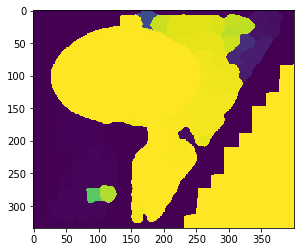

In [27]:
def seeSaliencyMap2 (F_cross, super_pixels) :
    height,width = super_pixels.shape
    Im1 = np.zeros((height,width))
    for i in range(height):
        for j in range(width):
            Im1[i,j] = F_cross[super_pixels[i,j]]
    Im2 = 1-Im1
    return Im1, Im2

S_map,F_map = seeSaliencyMap2 (F_y, super_pixels)

plt.figure()
plt.imshow(S_map)
plt.show()

Okay so foreground probability vector seems to be giving us areas that are being flagged as possibily foreground. It is picking up what we would consider to be the salient regions as well as other regions, for example, those on the right of the image.

We feed it once again into equation to get the Saliency probability for each super pixel. This time, for the ranking, we use the 90th percentile value of the rankings to set a threshold that we scale to. This gives us decent results. Note, here we don't want to use Tikhonov regularization because we want the most salient regions to be high.

1.0 5.76957259745825e-10


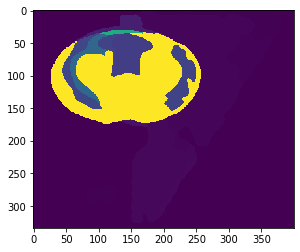

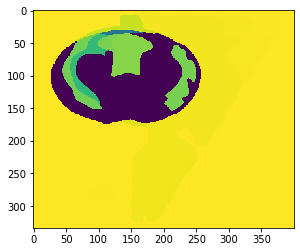

In [28]:
def calculateFinalSaliency(Diag,weight_matrix, numInd, F_y, mew = 0.99, thresh = 0.8, quant = 90) :
    inverseMat = np.linalg.pinv(Diag - mew*weight_matrix)
    f = np.matmul(inverseMat,F_y)
    m = np.percentile(f, quant)
    t = m*thresh
    g = (f>t)
    f[g] = t
    f = (f-np.min(f))/(np.max(f)-np.min(f)+0.000001)
    F = f.flatten()
    return F

S_star = calculateFinalSaliency(Diag,weight_matrix, numInd, F_y)

S_map,F_map = seeSaliencyMap2 (S_star, super_pixels)

#Im1 = Im1*1/(np.max(np.max(Im1)))

print(np.max(F_map), np.min(F_map))

#Im2 = (1 - F_map)

plt.figure()
plt.imshow(S_map)
plt.show()
    
plt.figure()
plt.imshow(F_map)
plt.show()

Frankly, this looks like an okay first estimate. However, it is still possible that our hyperparameters have not been set up right. This is something we will have to fix at the end. For now, let's try to aggregate everything into one function that is able to do a pyramid fusion of less partitioned images.

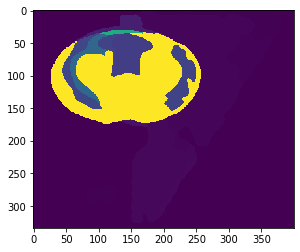

In [29]:
def getAggSaliencyMap(image,N_segments,Fi=F, b=bnds, l1=0.25, l2=0.45, l3=0.3, 
                      s2=-0.1, K=16, mew=0.99, damp =0.001, thresh = 0.8, quant = 90):
    
    super_pixels = SuperPixels (image, N_segments)
    
    Adjacency_ij, numInd = makeAdjMatrix(super_pixels)
    BorderSet = makeBorderset(super_pixels)
    
    lab_Image = makeLabImage(image)
    max_LM_filter = make_LM_Filter(image, Fi)
    reg_desc_col, reg_desc_tex, reg_desc_col_ave = makeRegionalDescriptors(super_pixels, lab_Image, max_LM_filter, numInd)
    
    GeoDist = GeodDist(reg_desc_col, reg_desc_tex, reg_desc_col_ave, Adjacency_ij, lamda1 = l1, lamda2 = l2, lamda3 =l3, K=K)
    GeoDist = dkstra(GeoDist)
    
    TwoHops, Edge_Group_2, Edge_Group_3, B_All = makeEdgeGroups(Adjacency_ij, BorderSet, numInd)
    
    weight_matrix = makeWeightMatrix(numInd,Adjacency_ij,TwoHops,Edge_Group_2,Edge_Group_3,GeoDist,B_All, sigma2 = s2)
    
    BoundRemove = chooseBorderExclude(BorderSet, reg_desc_col, reg_desc_tex)
    BorderSet.pop(BoundRemove)
    
    Diag = createDiagonal(weight_matrix)
    
    F_cross = calculateSaliencyprob(Diag, weight_matrix, BorderSet, numInd, mew=mew, damp = damp)
    
    S_orig = (1-F_cross[:,0])*(1-F_cross[:,1])*(1-F_cross[:,2])
    
    F_map,S_map = seeSaliencyMap (F_cross, super_pixels)
    
    S_ave = np.mean(S_orig)
    
    res = scipy.optimize.minimize(costFunction, S_orig, args=(S_ave, weight_matrix), 
                              jac=costJacFunction, method="L-BFGS-B",bounds=bnds[0:len(S_orig)])
    
    F_y = np.resize(res.x,(numInd,1))
    
    S_map1,F_map = seeSaliencyMap2 (F_y, super_pixels)
     
    S_star = calculateFinalSaliency(Diag,weight_matrix, numInd, F_y,mew = mew, thresh = thresh, quant =quant)

    S_map2,F_map = seeSaliencyMap2 (S_star, super_pixels)
    
    return S_map2, S_map1, S_map
                    
image = img_as_float(plt.imread(listOfImgName_X[0]))

S_map,_,_ = getAggSaliencyMap(image, numSegments)

plt.figure()
plt.imshow(S_map)
plt.show()

Okay so we have a function that will give us a saliency map, with hyperparameters as inputs.

First we need to create a pyramid of different sized images which are scaled with a gaussian weight function which is as we recall the 37th filter in the LM filter bank. We'll just use this filter to do this.

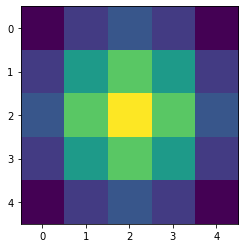

In [30]:
gaussian = F[22:27,22:27,37]

plt.figure()
plt.imshow(gaussian)
plt.show()


Now that we have a function that can generate a saliency map for an image at a certain length scale, we configure pyramid fusion scheme of images at multiple lengthscales as specified by the paper. This is done by rescaling the image at each level of the pyramid and applying a gaussian filter to it as well. Additionally, we scale the number of segments to shrink as per follows:-

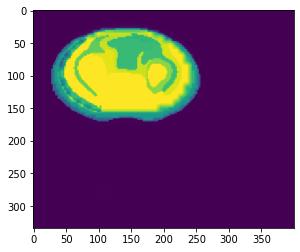

In [31]:
def createFusionSaliency(image, N_segments, PyrL=3, Fi = F, b = bnds, l1 = 0.25, l2 = 0.45, l3 =0.3, s2 = -0.1,K =16, 
                         mew=0.99, damp =0.001, thresh = 0.8, quant = 90):

    height, width, _ = image.shape

    #print(height, width)

    image_pyramid = {0:image}
    numSeg = {0:N_segments}
    
    Sal = image[:,:,0]*0
    
    gaussian = F[22:27,22:27,37]

    for l in range(1,PyrL+1):
        numSeg[l] = math.ceil(numSeg[l-1]/(2**(2*(l-1))))

        img = image_pyramid[l-1]
        img[:,:,0] = scipy.signal.fftconvolve(img[:,:,0], gaussian, mode='same')
        img[:,:,1] = scipy.signal.fftconvolve(img[:,:,1], gaussian, mode='same')
        img[:,:,2] = scipy.signal.fftconvolve(img[:,:,2], gaussian, mode='same')

        img = img/np.max(img)

        image_pyramid[l] = resize(img, (img.shape[0] // 2, img.shape[1] // 2),
                           anti_aliasing=True)
        
    for l in range(1,PyrL+1):
        img = image_pyramid[l]
        NumSeg = numSeg[l]
        
        s,_,_ = getAggSaliencyMap(img, NumSeg, Fi = Fi, b = b, l1 = l1, l2 = l2, l3 =l3, s2 = s2,K=K, 
                              mew=mew,damp =damp, thresh = thresh, quant = quant)
        
        s = resize(s, (height, width), anti_aliasing=False)
        
        Sal += s
        
    Sal = Sal/(PyrL)
    
    Sal = Sal/(np.max(Sal)+0.000001)
    
    return Sal

image = img_as_float(plt.imread(listOfImgName_X[0]))
S_map = createFusionSaliency(image, 300)

plt.figure()
plt.imshow(S_map)
plt.show()

With the multiscale fuzion, our saliency map seems to have all the right contours and looks suprisingly clean. Unf it is not obvious why different regions in the salient region are lighting up differently. The threshold may not be right. And this probably means that we will need to tune our hyperparameters on a training set. We can see this by trying a slightly different hyperparameter input.

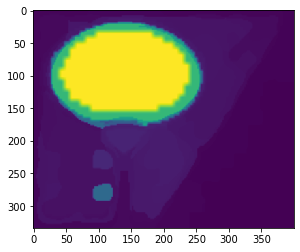

In [38]:
image = img_as_float(plt.imread(listOfImgName_X[0]))

S_map = createFusionSaliency(image, 300, quant = 80, thresh = 0.9)

plt.figure()
plt.imshow(S_map)
plt.show()


This seems to address the problem of the saliency prob being higher int the center but makes other regions also show now. We still probably need to tune the hyperparameters on a select few images to get the best balance (as our current hyperparameter is already different from that specified in the paper). We will use only 20 random images in the data base to do this. But first, let's agglomerate everything into one method function and call it to see how long it takes.

In [1]:
import time
import allMethodsCheck2 as SM
from skimage.util import img_as_float
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

listOfImgName_X = glob('MSRA10K_Imgs_GT/Imgs/*.jpg', recursive=True)

image = img_as_float(plt.imread(listOfImgName_X[0]))

t0 = time.clock()
S_map = SM.createFusionSaliency(image, 300, K=8, thresh = 0.85, quant = 90, damp1 = 0.001, s2 =-0.15)
t1 = time.clock()

print(t1-t0)

plt.figure()
plt.imshow(S_map)
plt.show()


C:\Users\ssahsan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


5.1878761


C:\Users\ssahsan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


<Figure size 640x480 with 1 Axes>

Now we establish define a cost function for the purpose of tuning the hyperparameters. As per the paper, this algorithm does not need training so we won't be picking a large number of images but we do need to find the optimal hyperparametes to use because even coarsely, one can see the recommended hyperparameters dont give optimal results here. We'll set the tuning routine on a small number of images (20 images) and exclude them from our final testing routine.

In [6]:
import random

random.shuffle(listOfImgName_X)

listOfImgName_Y = listOfImgName_X.copy()

for i in range(len(listOfImgName_Y)) :
    name = listOfImgName_Y[i]
    name = name[0:-3]+'png'
    listOfImgName_Y[i] = name
    
train_X = listOfImgName_X[0:20]
train_Y = listOfImgName_Y[0:20]

test_X = listOfImgName_X[20:]
test_Y = listOfImgName_Y[20:]

print(len(train_X))

20


Now we can save the train files and test files to text so that we can load them as required if we need to take a break. After running it, we can comment it out.

In [25]:
#with open('trainX.txt', 'w') as filehandle:
#    for listitem in train_X:
#        filehandle.write('%s\n' % listitem)
        
#with open('trainY.txt', 'w') as filehandle:
#    for listitem in train_Y:
#        filehandle.write('%s\n' % listitem)
        
#with open('testX.txt', 'w') as filehandle:
#    for listitem in test_X:
#        filehandle.write('%s\n' % listitem)
        
#with open('testY.txt', 'w') as filehandle:
#    for listitem in test_Y:
#        filehandle.write('%s\n' % listitem)

Now we have a checkpoint where we can load from just the cells below to continue porgress on testing out the algorithm.

In [2]:
import allMethodsCheck2 as SM
from skimage.util import img_as_float
import matplotlib.pyplot as plt
from glob import glob

train_X = []
train_Y = []
test_X = []
test_Y = []

with open('trainX.txt', 'r') as filehandle:
    train_X = [current_place.rstrip() for current_place in filehandle.readlines()]
    
with open('trainY.txt', 'r') as filehandle:
    train_Y = [current_place.rstrip() for current_place in filehandle.readlines()]
    
with open('testX.txt', 'r') as filehandle:
    test_X = [current_place.rstrip() for current_place in filehandle.readlines()]
    
with open('testY.txt', 'r') as filehandle:
    test_Y = [current_place.rstrip() for current_place in filehandle.readlines()]

First, we print out the color and texture cue images of the 20 selected images below. This is just to get a sense of what the cues look like in general.

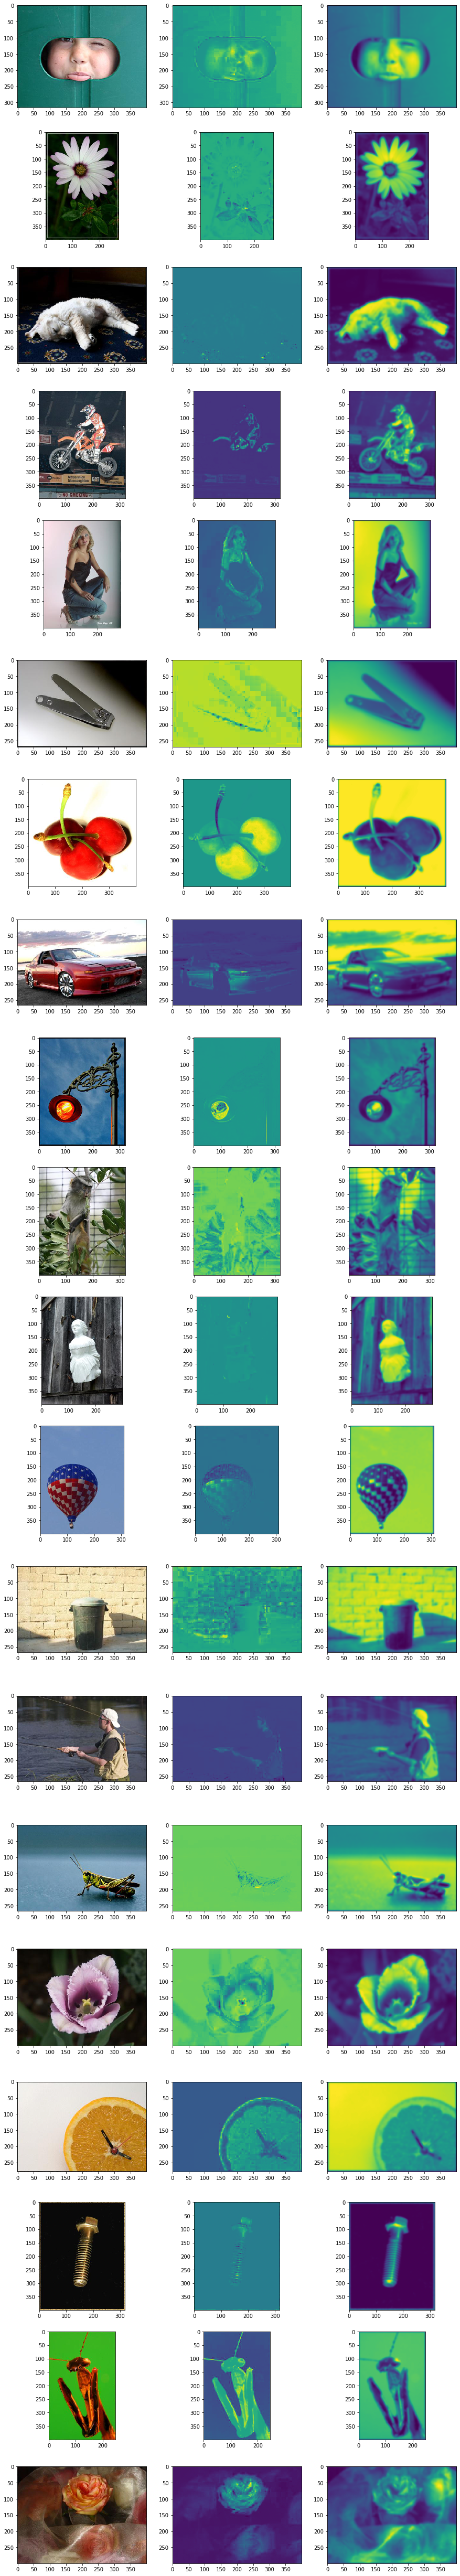

In [4]:
fig=plt.figure(figsize=(15, 90))
columns = 3
rows = 20

import lm
F = lm.makeLMfilters()

ax = []
j = 0

for i in range(0, rows):
    image = img_as_float(plt.imread(train_X[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    LabImage = SM.makeLabImage(image)
    LMImage = SM.make_LM_Filter(image, F)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(LabImage)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(LMImage)
plt.show()

Next we create the background Saliency estimators and multiply them to get the initial slaiency map on the right hand side.

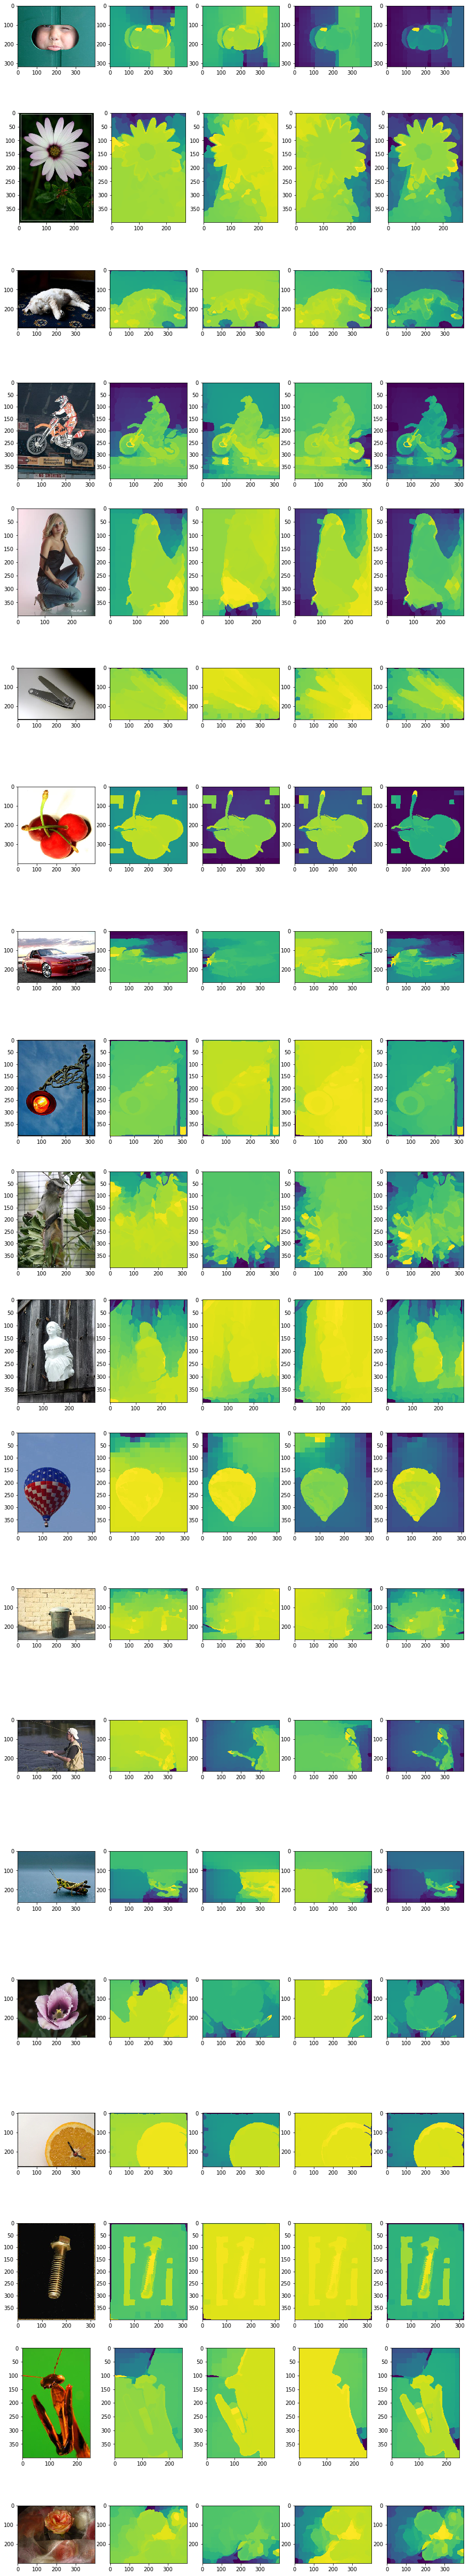

In [5]:
fig=plt.figure(figsize=(15, 90))
columns = 5
rows = 20

ax = []
j = 0

for i in range(0, rows):
    image = img_as_float(plt.imread(train_X[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    _,_,S_map = SM.getAggSaliencyMap(image, 300,  K=8, thresh = 0.85, quant = 90, damp1 = 0.001, s2 =-0.2)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map[:,:,0])
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map[:,:,1])
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map[:,:,2])
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map[:,:,0]*S_map[:,:,1]*S_map[:,:,2])
plt.show()

Now that we have the initial saliency map estimator, we create the optimal and final saliency map as well as the multi-scale fused map as well below.

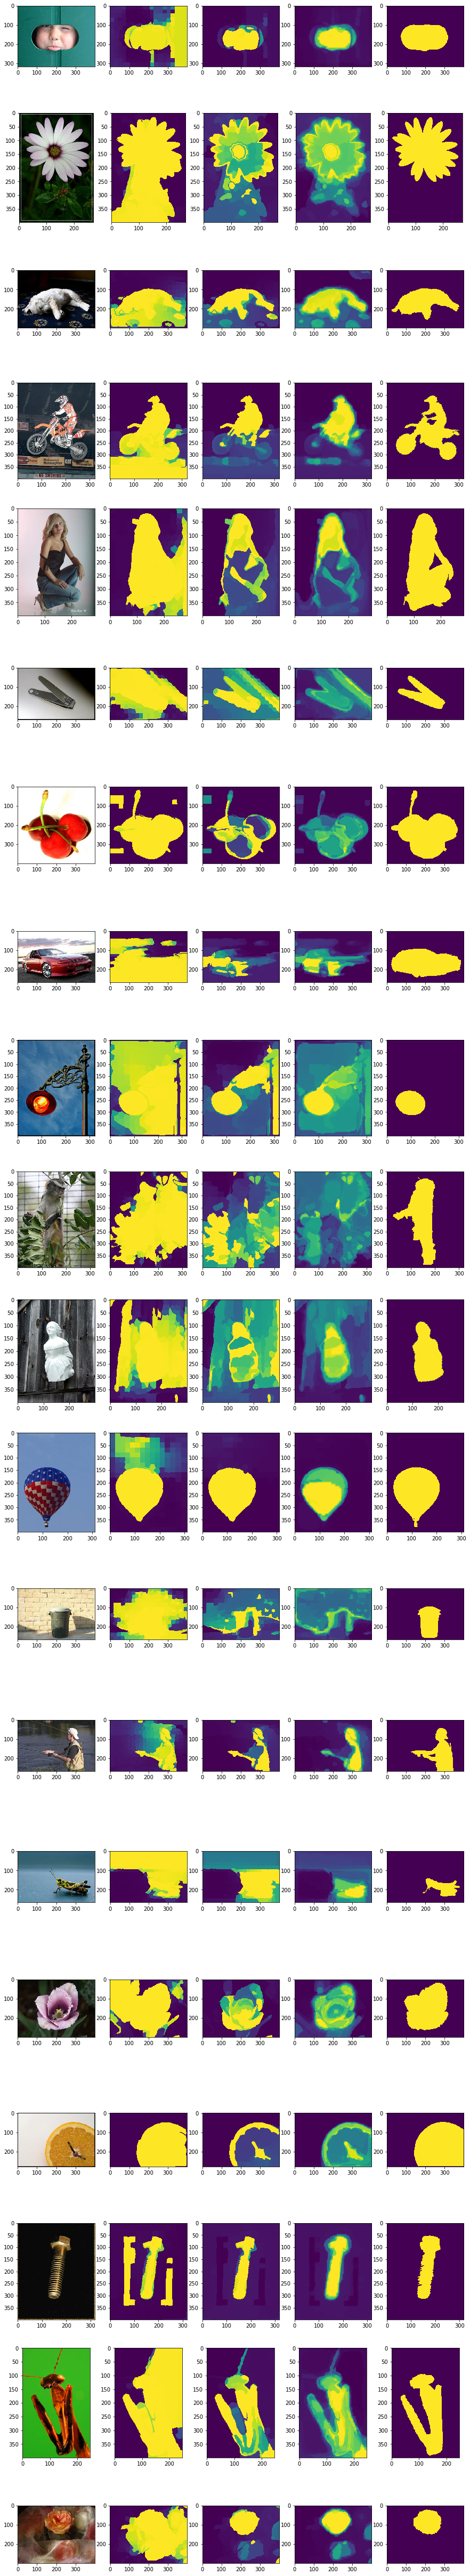

In [10]:
fig=plt.figure(figsize=(15, 90))
columns = 5
rows = 20

import lm
F = lm.makeLMfilters()

ax = []
j = 0

for i in range(0, rows):
    image = img_as_float(plt.imread(train_X[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    
    S_map,FinalSalMap,_ = SM.getAggSaliencyMap(image, 300, K=8, thresh = 0.85, quant = 90, damp1 = 0.001, s2 =-0.15)

    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(FinalSalMap)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map)
    
    S_map = SM.createFusionSaliency(image, 300, K=8, thresh = 0.85, quant = 90, damp1 = 0.001, s2 = -0.15)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map)
    image = img_as_float(plt.imread(train_Y[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    
    
plt.show()

One can definitely see the need for optimization here. We create a cost function we want to minime below.

In [18]:
def costTrainingHyperPar(HyperP, train_X, train_Y) :
    K = HyperP[0] 
    thresh = HyperP[1]
    quant = HyperP[2]
    damp1 = HyperP[3]
    s2 = HyperP[4]
    
    cost = 0
    cost1 = 0
    
    for i in range(len(train_X)) :
        
        image = img_as_float(plt.imread(train_X[i]))
        result = img_as_float(plt.imread(train_Y[i]))
    
        height, width, _ = image.shape
        
        S_map = SM.createFusionSaliency(image, 300, K=K, thresh = thresh, quant = quant, damp1 = damp1, s2 = s2)
        
        SalMap = S_map>0.5
        
        cost += (np.sum(np.abs(SalMap - result)))/(height*width)
        cost1 += (np.sum(np.abs(S_map - result)))/(height*width)
    
    return cost,cost1

No we create the parameters for the grid search below and run the gird search to generate the cost values in the grid.

In [3]:


K_i =[2,4,8,13,20]
thresh_i = [0.8, 0.85,0.9]
quant_i = [85,90,95]
damp1_i = [0.001]
s2_i = [-0.1,-0.15,-0.2]

cost_grid_search = np.zeros((len(K_i),len(thresh_i),len(quant_i),len(damp1_i),len(s2_i)))
cost1_grid_search = np.zeros((len(K_i),len(thresh_i),len(quant_i),len(damp1_i),len(s2_i)))

print(cost_grid_search.shape)

(5, 3, 3, 1, 3)


In [21]:
for i1 in range(len(K_i)):
    for i2 in range(len(thresh_i)):
        for i3 in range(len(quant_i)):
            for i4 in range(len(damp1_i)):
                for i5 in range(len(s2_i)):
                    HyperP = [K_i[i1],thresh_i[i2],quant_i[i3],damp1_i[i4],s2_i[i5]]
                    c,c1 = costTrainingHyperPar(HyperP, train_X, train_Y)
                    cost_grid_search[i1,i2,i3,i4,i5] = c
                    cost1_grid_search[i1,i2,i3,i4,i5] = c1

import pickle

with open('cost.pkl', 'wb') as f: 
    pickle.dump([cost_grid_search, cost1_grid_search], f)

In [48]:
i0 = np.unravel_index(np.argmin(cost_grid_search, axis=None), cost_grid_search.shape)
i1 = np.unravel_index(np.argmin(cost1_grid_search, axis=None), cost1_grid_search.shape)

print(i0)
print(i1)

print(np.min(cost_grid_search))

(2, 2, 2, 0, 2)
(3, 0, 2, 0, 0)
2.230581205928789


From the run above, we can see that the total cost 1- accuracy is 2.23 for 20 images, this gives us 89% accuracy for the tuned images above which is not bad. We can take a wuick look to see what the images look under ideal conditions from our relatively modest grid search.

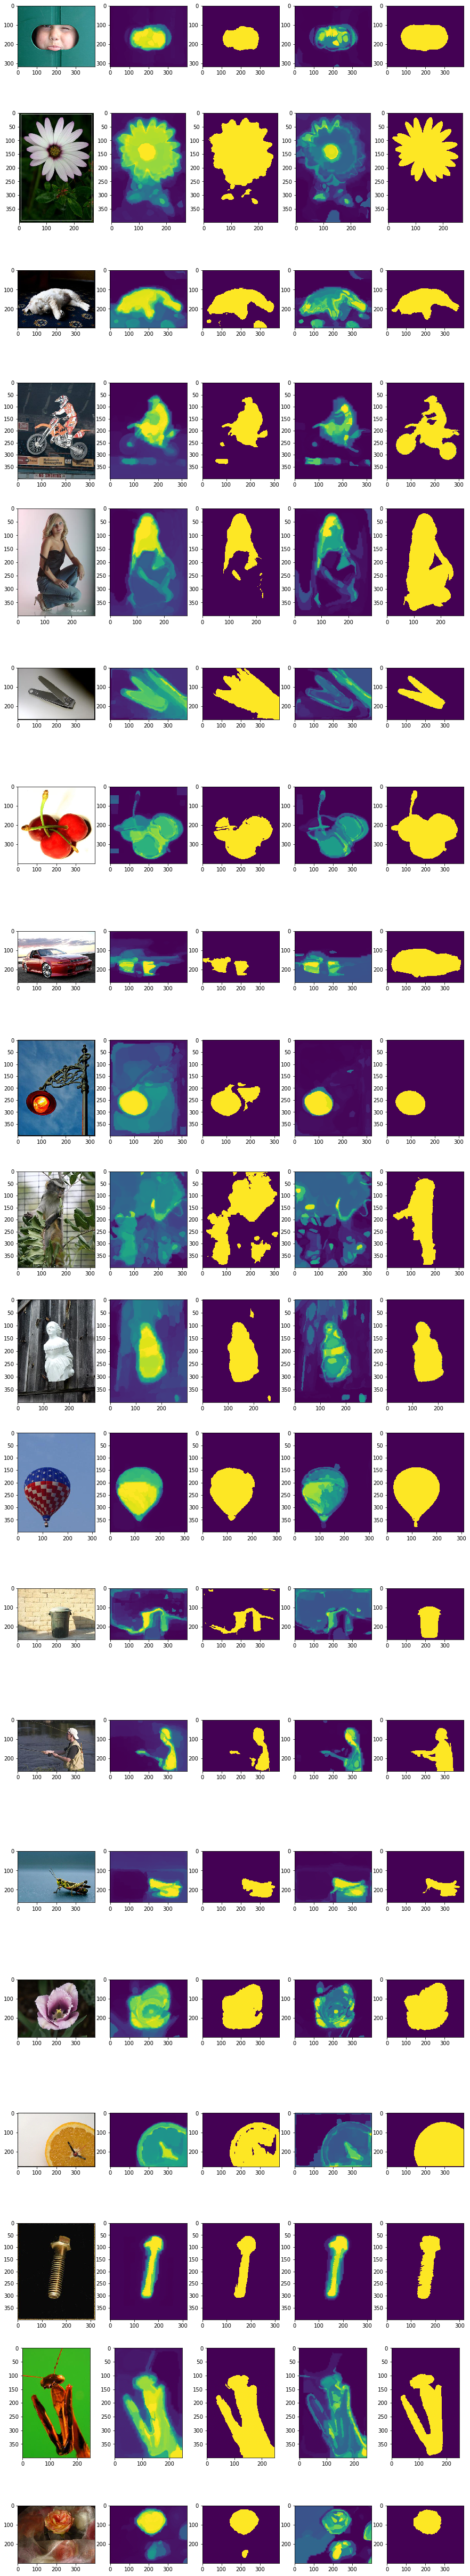

In [25]:
fig=plt.figure(figsize=(15, 90))
columns = 5
rows = 20

import lm
F = lm.makeLMfilters()

ax = []
j = 0

for i in range(0, rows):
    image = img_as_float(plt.imread(train_X[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    
    K = K_i[i0[0]]
    thresh = thresh_i[i0[1]]
    quant = quant_i[i0[2]]
    damp1 = damp1_i[i0[3]]
    s2 = s2_i[i0[4]]
    
    S_map = SM.createFusionSaliency(image, 300, K=K, thresh =thresh, quant = quant, damp1 = damp1, s2 = s2)
    SalMap = S_map>0.5
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(SalMap)
    
    K = K_i[i1[0]]
    thresh = thresh_i[i1[1]]
    quant = quant_i[i1[2]]
    damp1 = damp1_i[i1[3]]
    s2 = s2_i[i1[4]]
    
    S_map = SM.createFusionSaliency(image, 300, K=K, thresh =thresh, quant = quant, damp1 = damp1, s2 = s2)
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(S_map)
    image = img_as_float(plt.imread(train_Y[i]))
    j +=1
    ax.append(fig.add_subplot(rows, columns, j))
    plt.imshow(image)
    
    
plt.show()

In [4]:
import pickle

with open('cost.pkl', 'rb') as f:
    [cost_grid_search, cost1_grid_search] = pickle.load(f)

In [5]:
b = cost_grid_search*cost1_grid_search

i2 = np.unravel_index(np.argmin(b, axis=None), b.shape)

print(i2)

(2, 2, 2, 0, 2)


In [6]:
K = K_i[i2[0]]
thresh = thresh_i[i2[1]]
quant = quant_i[i2[2]]
damp1 = damp1_i[i2[3]]
s2 = s2_i[i2[4]]

After uplaoding our ideal hyperparamters from the grid search, we can run our model on 300 random images for both our implementation of the grab algorithm and the benchmark contrast based algorithm.

In [7]:
dir1 = 'MSRA10K/Grab'

#print(dir1 + test_X[0][20:])

for i in range(300):
    
    a = test_X[i][20:]
    b = dir1+a
    
    image = img_as_float(plt.imread(test_X[i]))
    
    S_map = SM.createFusionSaliency(image, 300, K=K, thresh =thresh, quant = quant, damp1 = damp1, s2 = s2)
    plt.imsave(b, S_map)
    

In [8]:
dir2 = 'MSRA10K/Contrast'

#print(dir1 + test_X[0][20:])

from saliencyfilters import SaliencyFilters

sf = SaliencyFilters()

saliency = sf.compute_saliency(image)


for i in range(300):
    
    a = test_X[i][20:]
    b = dir2+a
    
    image = img_as_float(plt.imread(test_X[i]))
    
    saliency = sf.compute_saliency(image)
    plt.imsave(b, saliency)

Now we can calculate the confusion matrix of the test images that we have saved. calculating True Postives, False Positives, and False Negantives. The False Positives cna be calculated by subtracting these 3 values from 300.

In [36]:
from glob import glob

threshold = np.arange(0.30,0.70,0.01)

dir1 = 'MSRA10K_Imgs_GT/Imgs/'

filtype = 'png'

Grab_Test = glob('MSRA10K/Grab/*', recursive=True)
Cont_Test = glob('MSRA10K/Contrast/*', recursive=True)
    
GrabROC = np.zeros((2,len(threshold)))
ContROC = np.zeros((2,len(threshold)))

for i in range(len(threshold)):
    t = threshold[i]
    TP = 0
    FP = 0
    FN = 0
    
    for img in Grab_Test:
        image = img_as_float(plt.imread(img))
        Sal = image[:,:,0]>t
        
        res_img = dir1 + img[13:-3] + filtype
        image = img_as_float(plt.imread(res_img))
        
        height, width = image.shape
        
        TP += np.sum(image*Sal)/(height*width)
        
        Z = Sal-image
        FP += np.sum(Z==1)/(height*width)
        FN += np.sum(Z==-1)/(height*width)
    
    GrabROC[0,i] = TP/(TP+FP)
    GrabROC[1,i] = TP/(TP+FN)
    
    TP = 0
    FP = 0
    FN = 0
    
    for img in Cont_Test:
        image = img_as_float(plt.imread(img))
        Sal = image[:,:,0]>t
        
        res_img = dir1 + img[17:-3] + filtype
        image = img_as_float(plt.imread(res_img))
        
        height, width = image.shape
        
        TP += np.sum(image*Sal)/(height*width)
        
        Z = Sal-image
        FP += np.sum(Z==1)/(height*width)
        FN += np.sum(Z==-1)/(height*width)
    
    ContROC[0,i] = TP/(TP+FP)
    ContROC[1,i] = TP/(TP+FN)


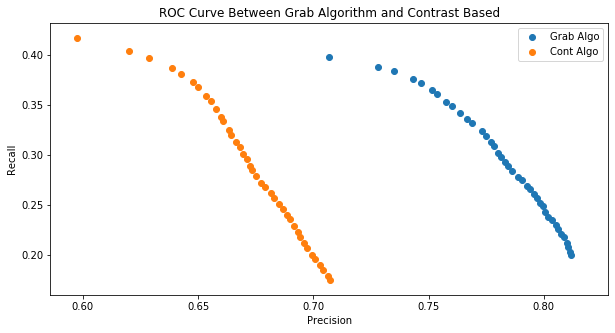

In [37]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('ROC Curve Between Grab Algorithm and Contrast Based')
ax.scatter(x=GrabROC[0,:],y=GrabROC[1,:],label='Grab Algo')
ax.scatter(ContROC[0,:],ContROC[1,:],label='Cont Algo')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='best')
plt.show()

In [49]:
print (TP, FP, FN)

12.021191420859802 4.974624444471539 56.54916100861379


In [50]:
TN = 300-TP-FP-FN
print(TN)

226.45502312605487


In [51]:
print ((TP+TN)/300)

0.7949207151563822


Our test accuracy as seen above is close to 80% with our precision to recall curve outperforming the benchmark model by a significant amount. This concludes our testing and code.